In [24]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import seaborn as sns
import matplotlib.colors




cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue",'white',"red"])


models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

to_data = '../data/'
to_norm = '../data/Norm/'
short_names = ['P03','P04','P05','P06','P07','P08','P09','P10','P12','P13','P14','P15','P19','P20','P22','P23','P26']


📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in C:\Users\marti\.celltypist\data\models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [12]:
file_names = open (to_data+'file_list.txt','r')
file_names_list = []
for name in file_names:
    file_names_list.append(name.replace('\n',''))


In [13]:
# Quality cells:
n_genes_threshold = 500
n_barcodes_threshold = 1500
pct_mito_threshold = 15
# Cells with >1% of transcripts representing erythroid genes (HBA1, HBA2, HBB, HBM, and ALAS2) were removed forrm the analissis.
e_genes = ['HBA1','HBA1','HBB','HBM','ALAS1']
e_genes_threshold = 0.01
#Parameters:
nei = [10,15,20,25,30]
umapp = [0.25,0.5,1,1.25,1.5]
resolution = [0.1,0.2,0.25,0.5]

In [14]:
def data_manipulation(selected,neighbor,u,res):
    
    
    
    adata = sc.read_10x_mtx(to_data , var_names='gene_symbols',cache=True,prefix=file_names_list[selected])

    
    
        # Set a random seed for reproducibility
    np.random.seed = 42

    subset_fraction = 0.1 
    adata_concat = adata
    subset_indices = np.random.choice(adata_concat.n_obs, size=int(adata_concat.n_obs * subset_fraction), replace=False)
    adata = adata_concat[subset_indices, :]
    #QC
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    #print(adata)
    sc.pp.filter_cells(adata, min_counts = n_barcodes_threshold, min_genes = None, inplace=True) #Select cells by molecular identiers
    sc.pp.filter_cells(adata, min_counts = None, min_genes = n_genes_threshold, inplace=True) #select cells by detectable gens
    adata = adata[adata.obs.n_genes_by_counts < 5000, :]
    adata = adata[adata.obs.pct_counts_mt<pct_mito_threshold,:]
    #print(adata)
    adata.obs['erythroid_gene_counts'] = adata[:, e_genes].X.sum(axis=1)
    adata.obs['erythroid_gene_percentage'] = (
        adata.obs['erythroid_gene_counts'] / adata.obs['total_counts'] * 100
    )
    num_cells_excluded = sum(adata.obs['erythroid_gene_percentage'] > 1)
    print(f"Number of cells excluded: {num_cells_excluded}")
    adata = adata[adata.obs['erythroid_gene_percentage'] < 1]
    adata.obs = adata.obs.drop(['erythroid_gene_counts', 'erythroid_gene_percentage'], axis=1)

    
    adata.layers['counts'] = adata.X
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

    
    
    sc.pp.highly_variable_genes(adata, layer="log1p_norm")

    
    
    #Dimention reducction:
    sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True,random_state =1)
    #sc.pl.pca_scatter(adata, color="total_counts")
    sc.tl.tsne(adata, use_rep="X_pca",random_state =1)
    #sc.pl.tsne(adata, color="total_counts")
    sc.pp.neighbors(adata,n_neighbors = neighbor,random_state =1 )
    sc.tl.umap(adata,random_state =1,min_dist = u,spread = u+0.5)
    #sc.pl.umap(adata, color="total_counts")
    sc.tl.leiden(adata,resolution=res)
    
    
    
    
    
    
    #Annotation:
    adata_celltypist = adata.copy()  # make a copy of our adata
    adata_celltypist.X = adata.layers['counts'] # set adata.X to raw counts
    sc.pp.normalize_per_cell(
        adata_celltypist, counts_per_cell_after=10**4
    )  # normalize to 10,000 counts per cell
    sc.pp.log1p(adata_celltypist)  # log-transform
    # make .X dense instead of sparse, for compatibility with celltypist:
    adata_celltypist.X = adata_celltypist.X.toarray()
    model_low = models.Model.load(model="Immune_All_Low.pkl")
    model_high = models.Model.load(model="Immune_All_High.pkl")
    predictions_high = celltypist.annotate(
        adata_celltypist, model=model_high, majority_voting=True
    )
    predictions_high_adata = predictions_high.to_adata()
    adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "majority_voting"
    ]
    adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "conf_score"
    ]
    predictions_low = celltypist.annotate(
        adata_celltypist, model=model_low, majority_voting=True
    )
    predictions_low_adata = predictions_low.to_adata()
    
    adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "majority_voting"
    ]
    adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "conf_score"
    ]
    return (adata)
    
    

In [15]:
'''
for n in nei:
    for u in umapp:
        for res in resolution:
            adata_ref =data_manipulation(0,n,u,res)
            adata_list = []

            for i in range (1,len(file_names_list)):
                adata = data_manipulation(i,n,u,res)
                var_names = adata_ref.var_names.intersection(adata.var_names)
                adata_ref = adata_ref[:, var_names]
                adata = adata[:, var_names]
                sc.tl.ingest(adata, adata_ref, obs="leiden")
                adata_list.append(adata)
                print(f'{i}/{len(file_names_list)}')
                if i <1 :
                    concat =adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])
                    test(concat)
            adata =adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])

            sc.pp.scale(adata, max_value=10)
            print('Sample: ',short_names[i])
            print('Resolution: ',res)
            print('Umap: ',u)
            print('N_neighbors: ', n)
            
            sc.pl.umap(
                adata,
                color=['batch','leiden'],
                frameon=False,
                sort_order=False,
                wspace=1,
            )
            sc.pl.umap(
                adata,
                color=["celltypist_cell_label_coarse", "KRT19"],
                frameon=False,
                sort_order=True,
                wspace=1,
            )       
            adata_concat = adata.copy()
            remarked_cell_type = "Epithelial cells"

            adata_concat.obs['is_remarked_cell'] = adata_concat.obs['celltypist_cell_label_coarse'] == remarked_cell_type

            # Convert the column to categorical dtype
            adata_concat.obs['is_remarked_cell'] = pd.Categorical(adata_concat.obs['is_remarked_cell'])

            # Plot UMAP with color based on the new categorical column
            sc.pl.umap(
                adata_concat,
                color='is_remarked_cell',
                palette=['lightgrey', 'red'],  # Choose appropriate colors
                frameon=False,
                sort_order=True,
                wspace=1,
            )
            '''

'\nfor n in nei:\n    for u in umapp:\n        for res in resolution:\n            adata_ref =data_manipulation(0,n,u,res)\n            adata_list = []\n\n            for i in range (1,len(file_names_list)):\n                adata = data_manipulation(i,n,u,res)\n                var_names = adata_ref.var_names.intersection(adata.var_names)\n                adata_ref = adata_ref[:, var_names]\n                adata = adata[:, var_names]\n                sc.tl.ingest(adata, adata_ref, obs="leiden")\n                adata_list.append(adata)\n                print(f\'{i}/{len(file_names_list)}\')\n                if i <1 :\n                    concat =adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])\n                    test(concat)\n            adata =adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])\n\n            sc.pp.scale(adata, max_value=10)\n            print(\'Sample: \',short_names[i])\n            print(\'Resolu

In [16]:
def data_manipulation2(selected):
    
    
    
    adata = sc.read_10x_mtx(to_data , var_names='gene_symbols',cache=True,prefix=file_names_list[selected])

    
    
        # Set a random seed for reproducibility
    np.random.seed = 42

    subset_fraction = 0.1 
    adata_concat = adata
    subset_indices = np.random.choice(adata_concat.n_obs, size=int(adata_concat.n_obs * subset_fraction), replace=False)
    adata = adata_concat[subset_indices, :]
    #QC
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    #print(adata)
    sc.pp.filter_cells(adata, min_counts = n_barcodes_threshold, min_genes = None, inplace=True) #Select cells by molecular identiers
    sc.pp.filter_cells(adata, min_counts = None, min_genes = n_genes_threshold, inplace=True) #select cells by detectable gens
    adata = adata[adata.obs.n_genes_by_counts < 5000, :]
    adata = adata[adata.obs.pct_counts_mt<pct_mito_threshold,:]
    #print(adata)
    adata.obs['erythroid_gene_counts'] = adata[:, e_genes].X.sum(axis=1)
    adata.obs['erythroid_gene_percentage'] = (
        adata.obs['erythroid_gene_counts'] / adata.obs['total_counts'] * 100
    )
    num_cells_excluded = sum(adata.obs['erythroid_gene_percentage'] > 1)
    #print(f"Number of cells excluded: {num_cells_excluded}")
    adata = adata[adata.obs['erythroid_gene_percentage'] < 1]
    adata.obs = adata.obs.drop(['erythroid_gene_counts', 'erythroid_gene_percentage'], axis=1)

    
    adata.layers['counts'] = adata.X

    return (adata)
    
def dim(adata,neighbor,u,res):
    
    
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

    
    
    sc.pp.highly_variable_genes(adata, layer="log1p_norm")
    #Dimention reducction:
    sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True,random_state =1)
    #sc.pl.pca_scatter(adata, color="total_counts")
    sc.tl.tsne(adata, use_rep="X_pca",random_state =1)
    #sc.pl.tsne(adata, color="total_counts")
    sc.pp.neighbors(adata,n_neighbors = neighbor,random_state =1 )
    sc.tl.umap(adata,random_state =1,min_dist = u,spread = u+0.5)
    #sc.pl.umap(adata, color="total_counts")
    sc.tl.leiden(adata,resolution=res,random_state =1)




    sc.pl.umap(
        adata,
        color= ["KRT19",'leiden'],
        frameon=False,
        sort_order=True,
        wspace=1,
        vmax = 2.5,
        color_map = cmap,
        size = 40
        #=['#ff0000','#1100ff']
    )
    
    return(adata)
    
    
    
def ann(adata):  
    #Annotation:
    adata_celltypist = adata.copy()  # make a copy of our adata
    #adata_celltypist.X = adata.layers['counts'] # set adata.X to raw counts
    sc.pp.normalize_per_cell(
        adata_celltypist, counts_per_cell_after=10**4
    )  # normalize to 10,000 counts per cell
    sc.pp.log1p(adata_celltypist)  # log-transform
    # make .X dense instead of sparse, for compatibility with celltypist:
    adata_celltypist.X = adata_celltypist.X.toarray()
    model_low = models.Model.load(model="Immune_All_Low.pkl")
    model_high = models.Model.load(model="Immune_All_High.pkl")
    predictions_high = celltypist.annotate(
        adata_celltypist, model=model_high, majority_voting=True
    )
    predictions_high_adata = predictions_high.to_adata()
    adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "majority_voting"
    ]
    adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "conf_score"
    ]
    predictions_low = celltypist.annotate(
        adata_celltypist, model=model_low, majority_voting=True
    )
    predictions_low_adata = predictions_low.to_adata()
    
    adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "majority_voting"
    ]
    adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "conf_score"
    ]
    return (adata)


... storing 'feature_types' as categorical


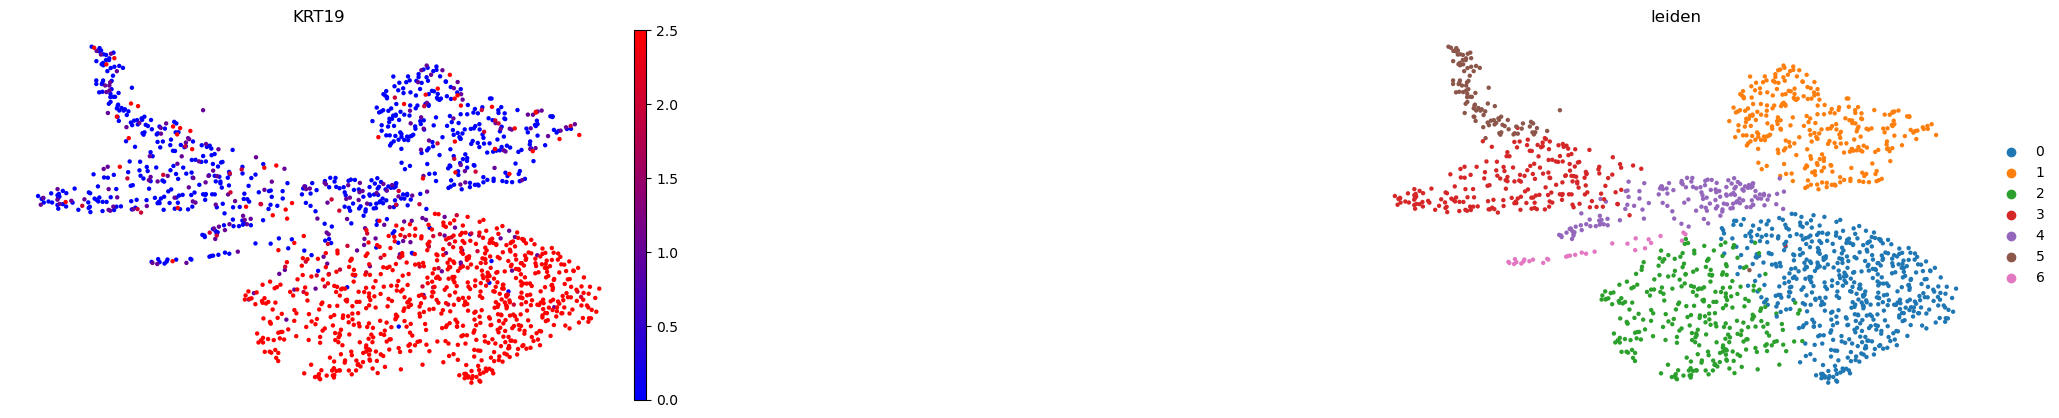

N_cells:  176


... storing 'feature_types' as categorical


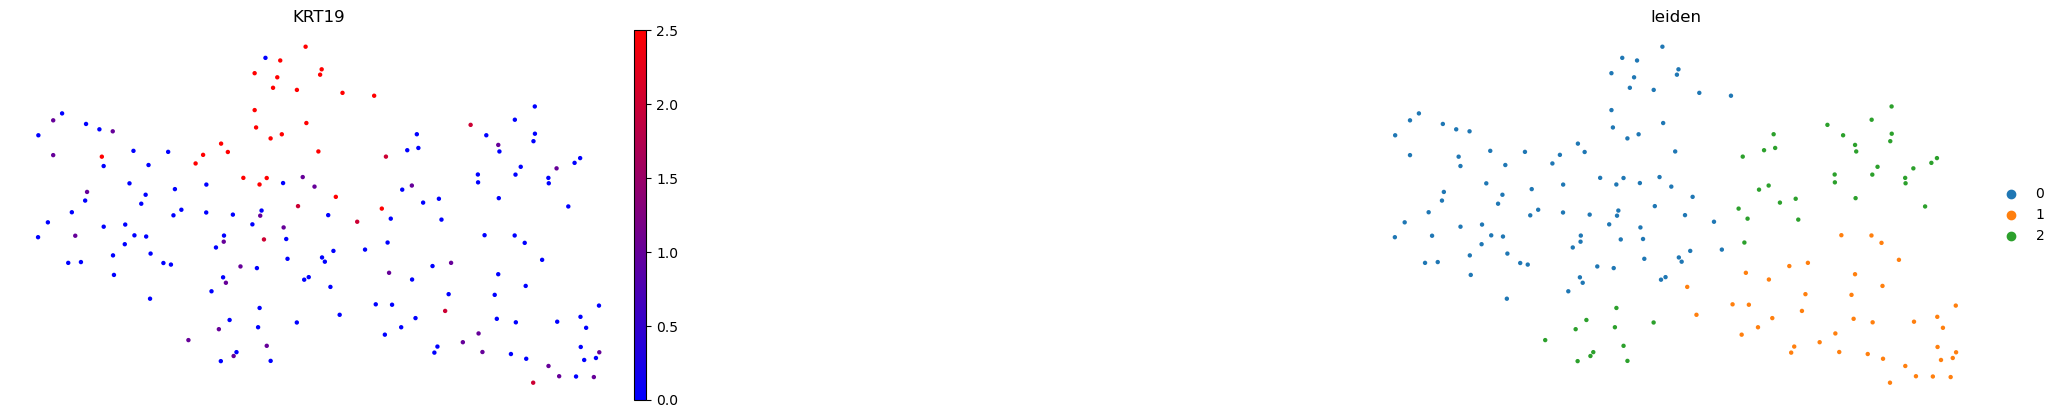

1/17
N_cells:  1042


... storing 'feature_types' as categorical


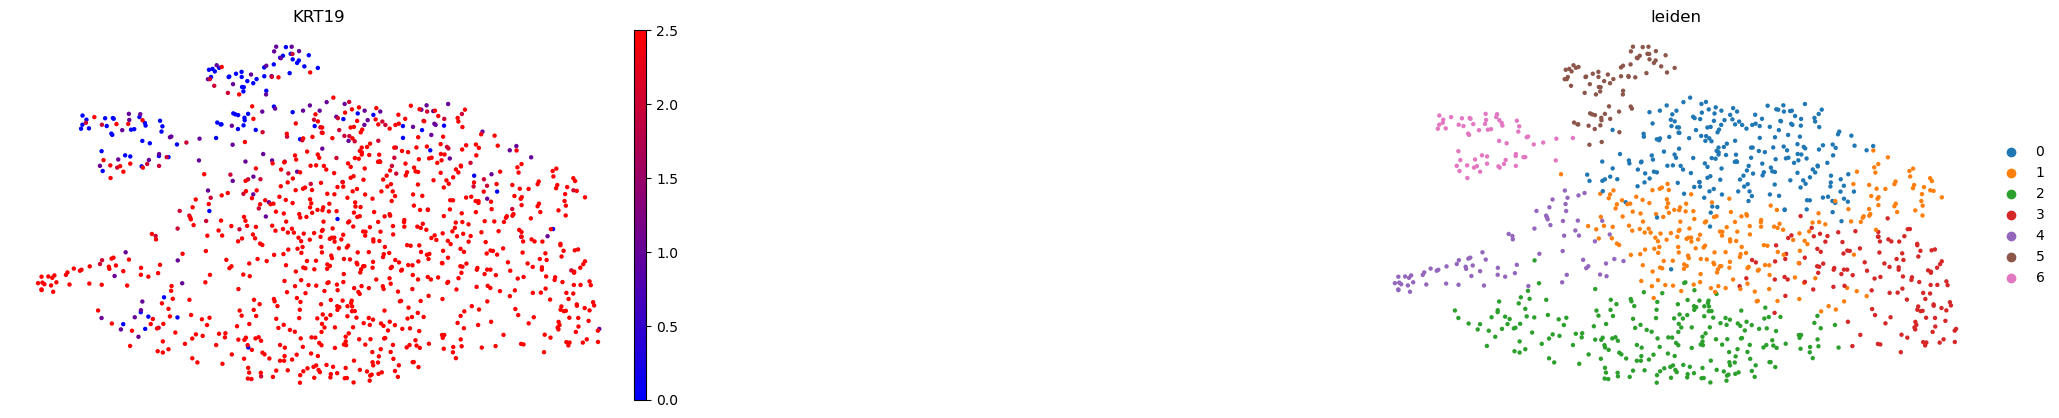

2/17
N_cells:  113


... storing 'feature_types' as categorical


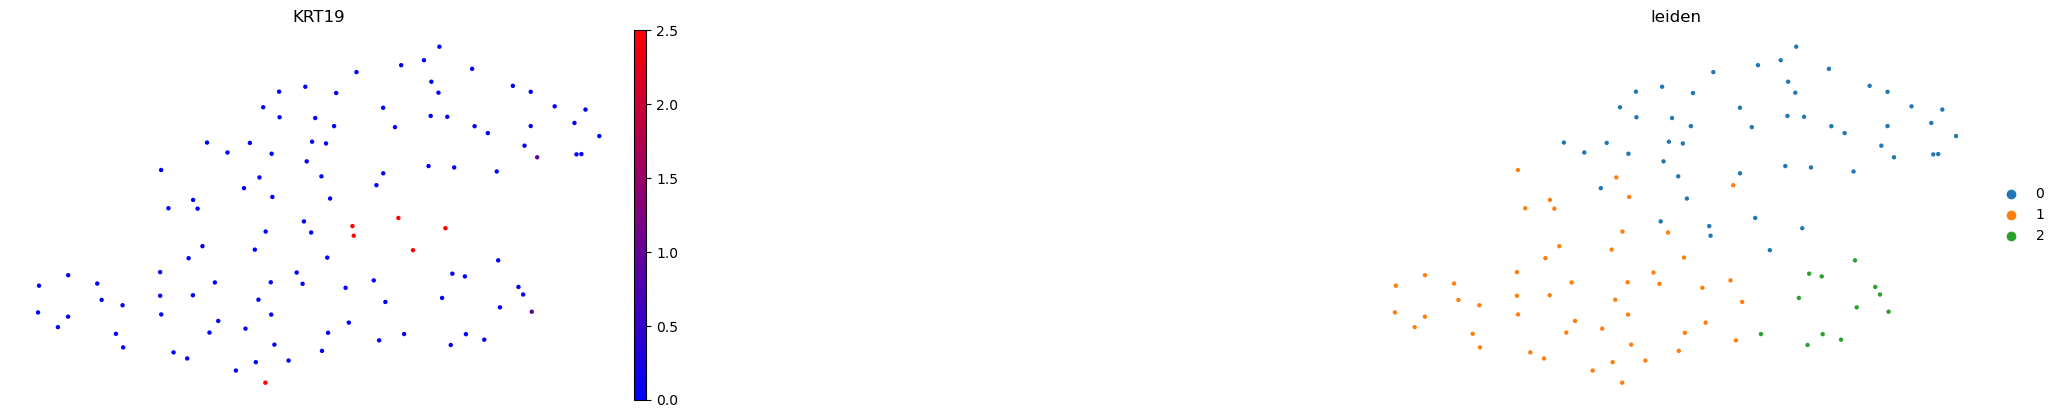

3/17
N_cells:  335


... storing 'feature_types' as categorical


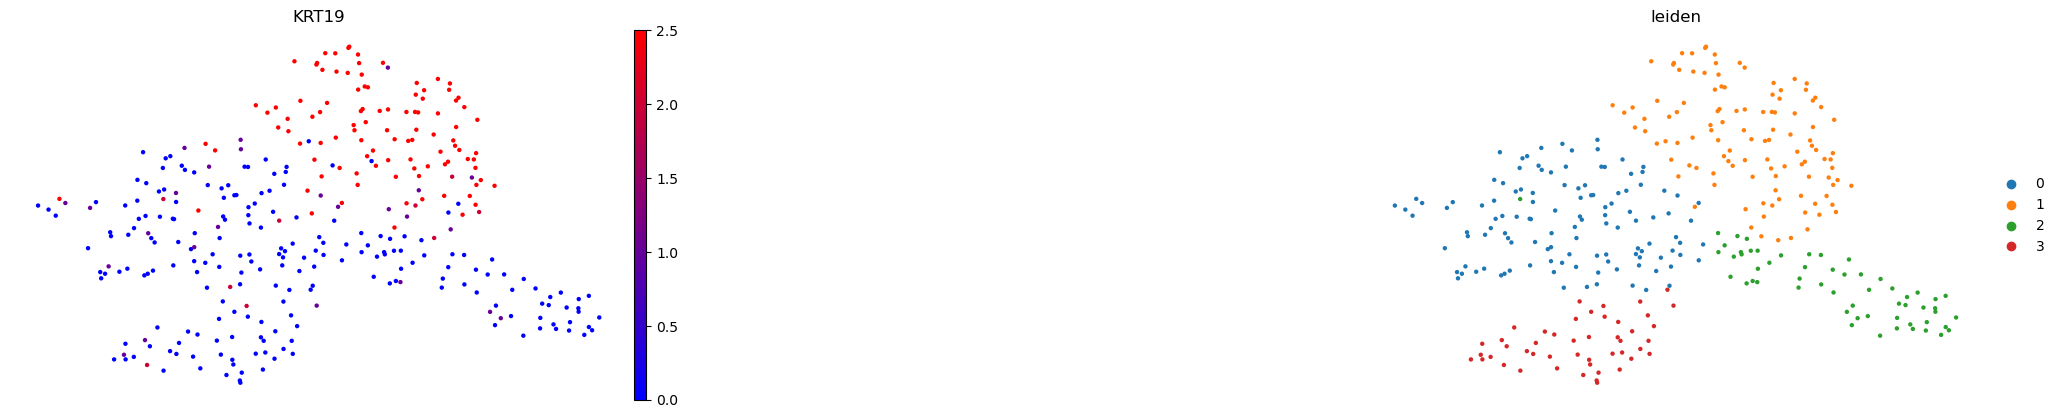

4/17
N_cells:  416


... storing 'feature_types' as categorical


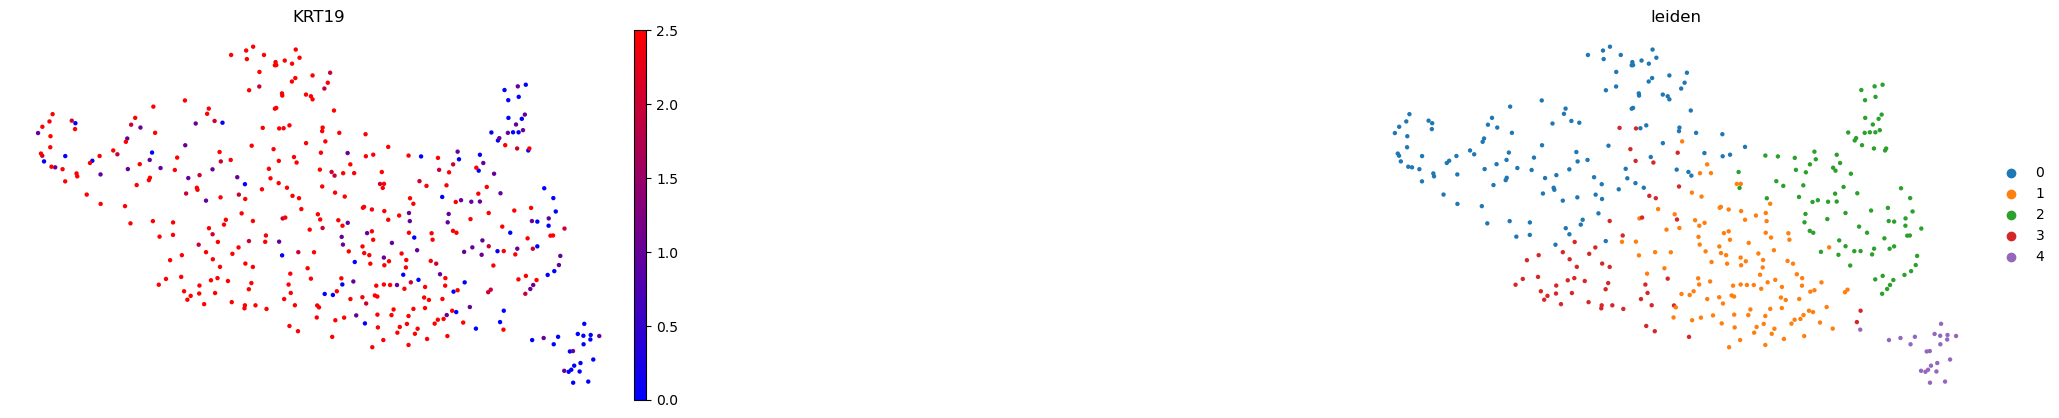

5/17
N_cells:  105


... storing 'feature_types' as categorical


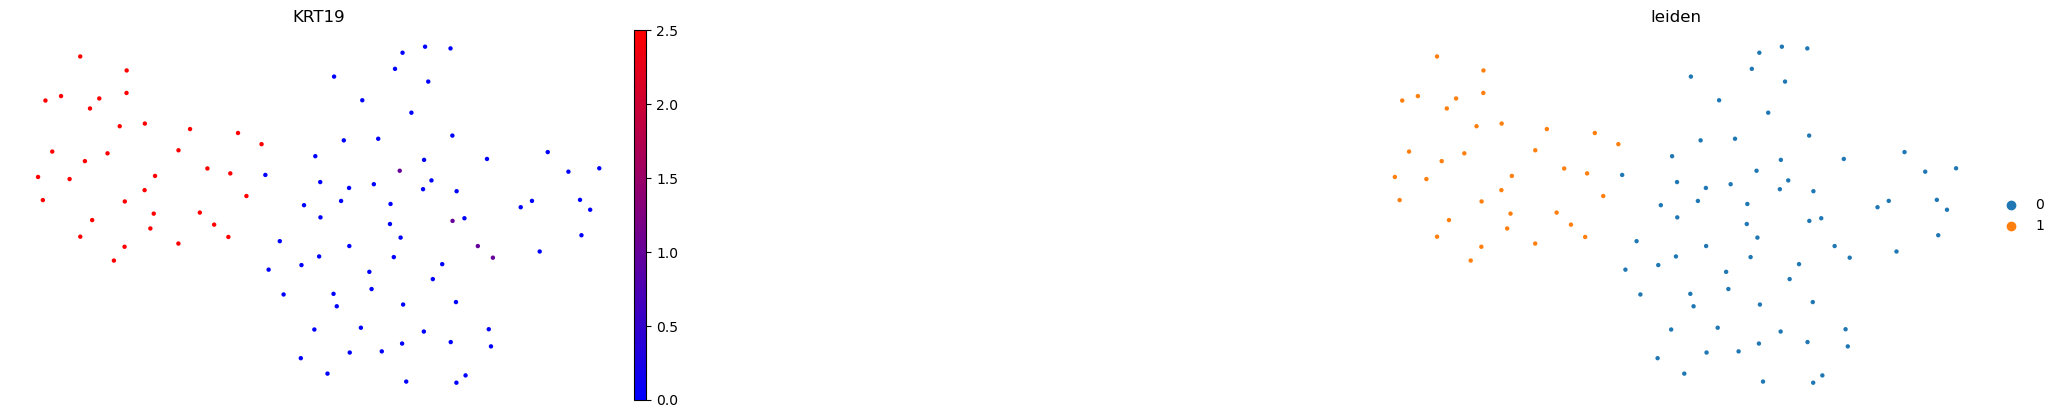

6/17
N_cells:  324


... storing 'feature_types' as categorical


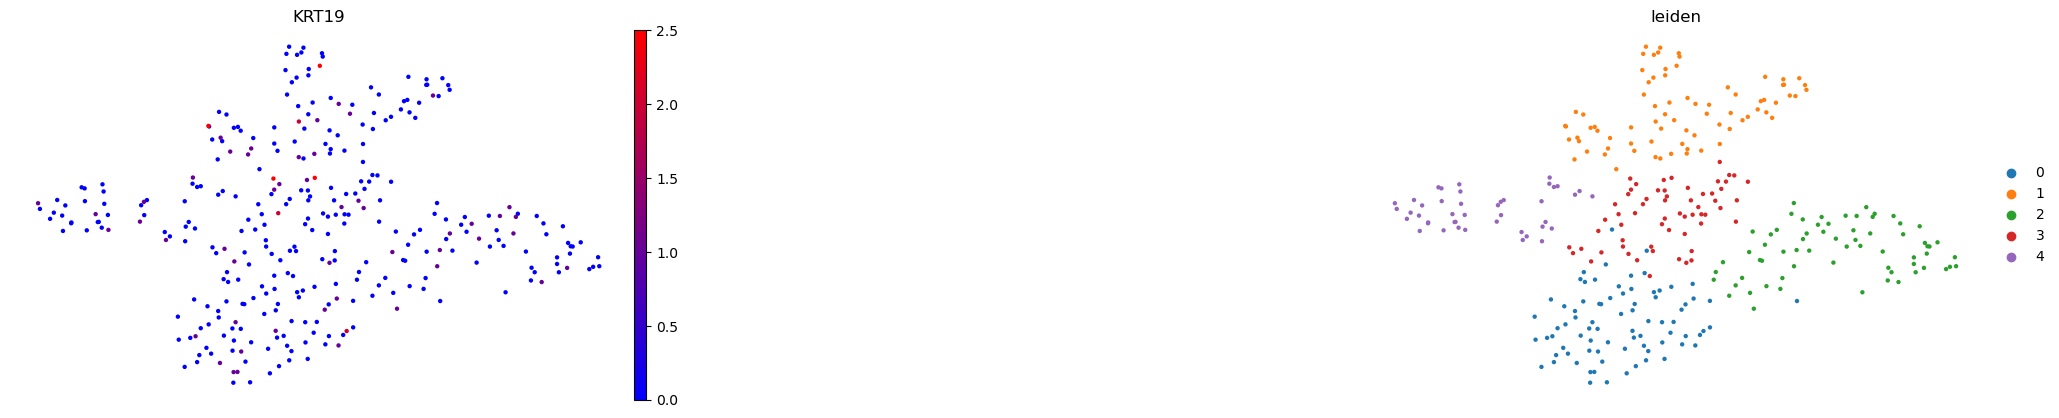

7/17
N_cells:  187


... storing 'feature_types' as categorical


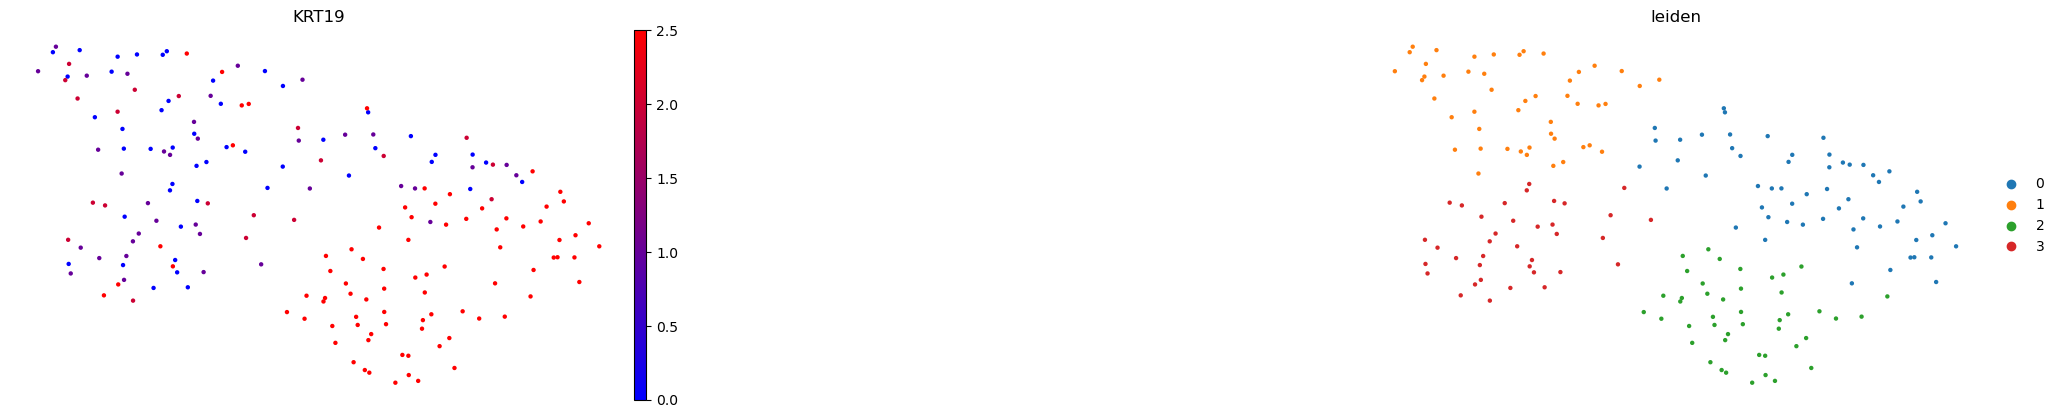

8/17
N_cells:  174


... storing 'feature_types' as categorical


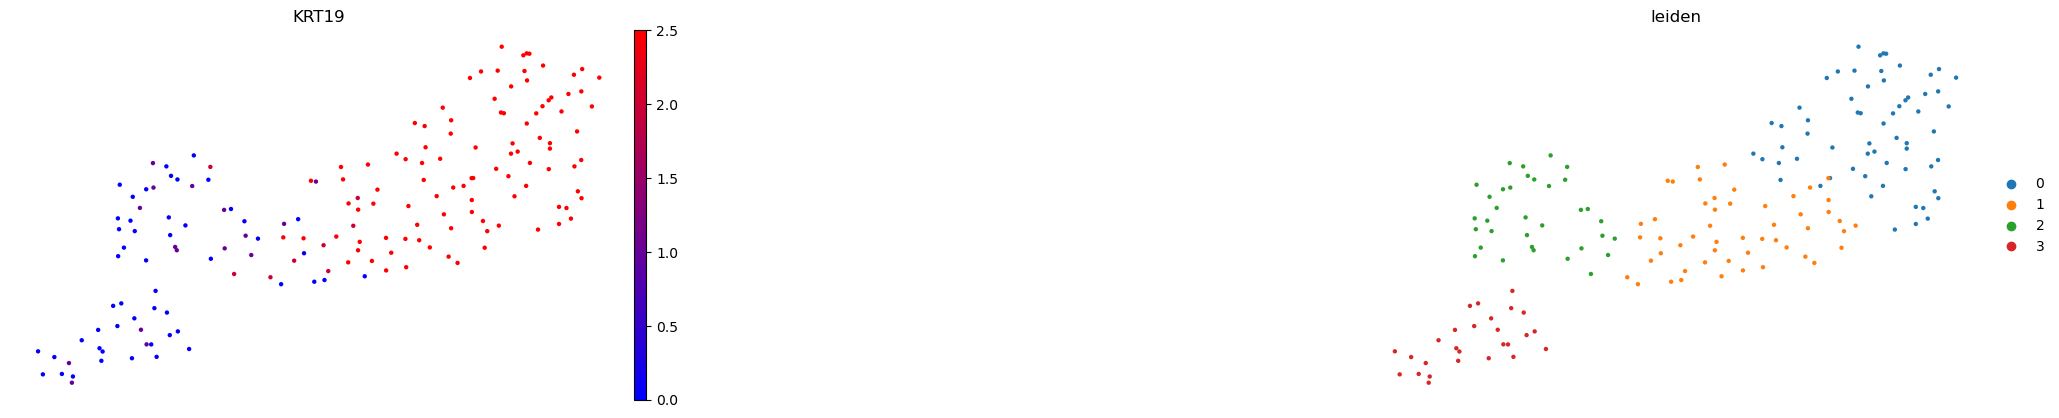

9/17
N_cells:  1238


... storing 'feature_types' as categorical


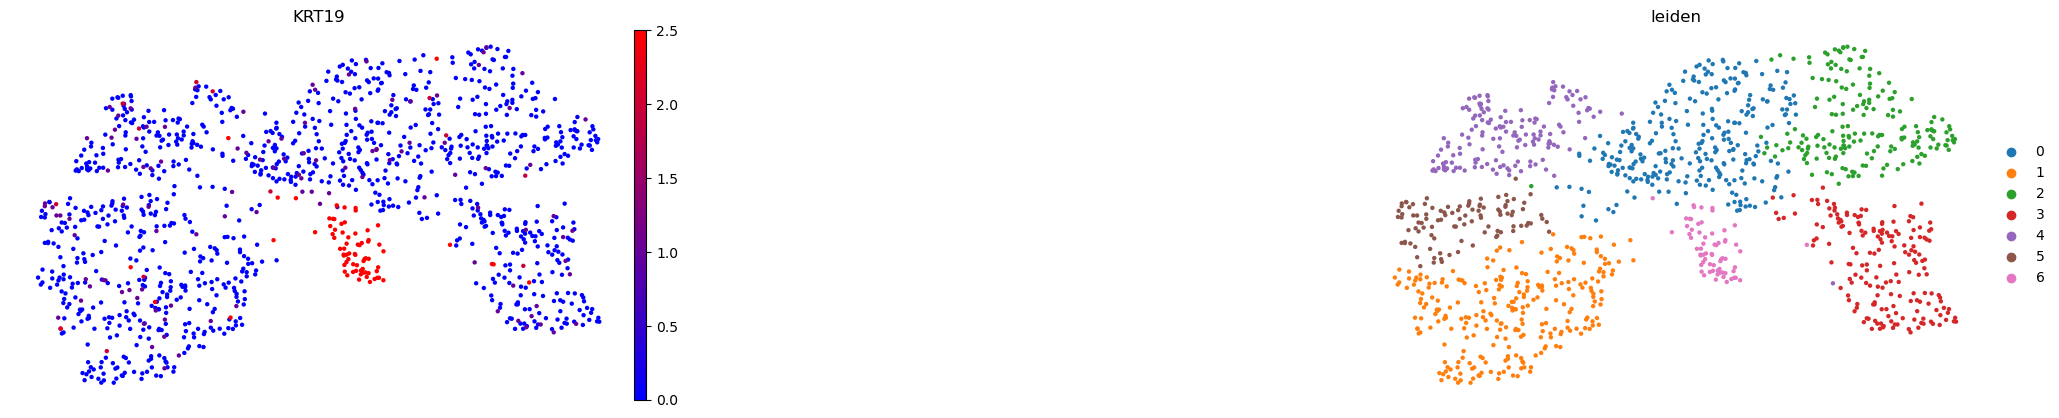

10/17
N_cells:  559


... storing 'feature_types' as categorical


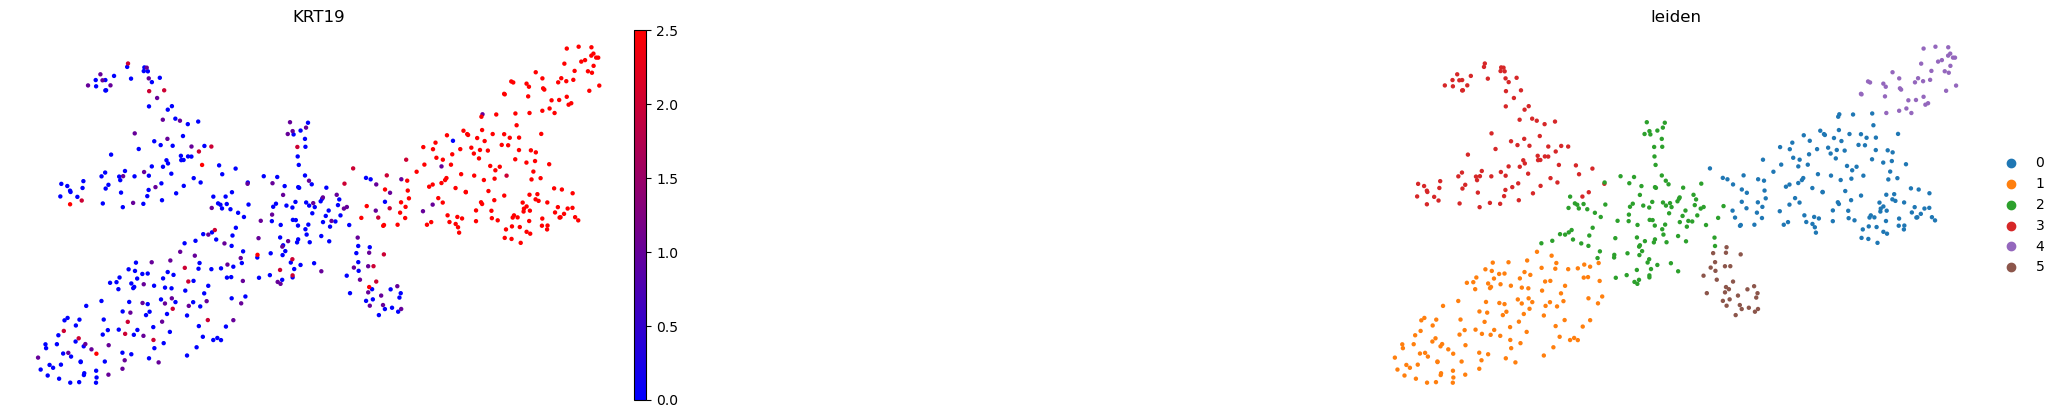

11/17
N_cells:  1053


... storing 'feature_types' as categorical


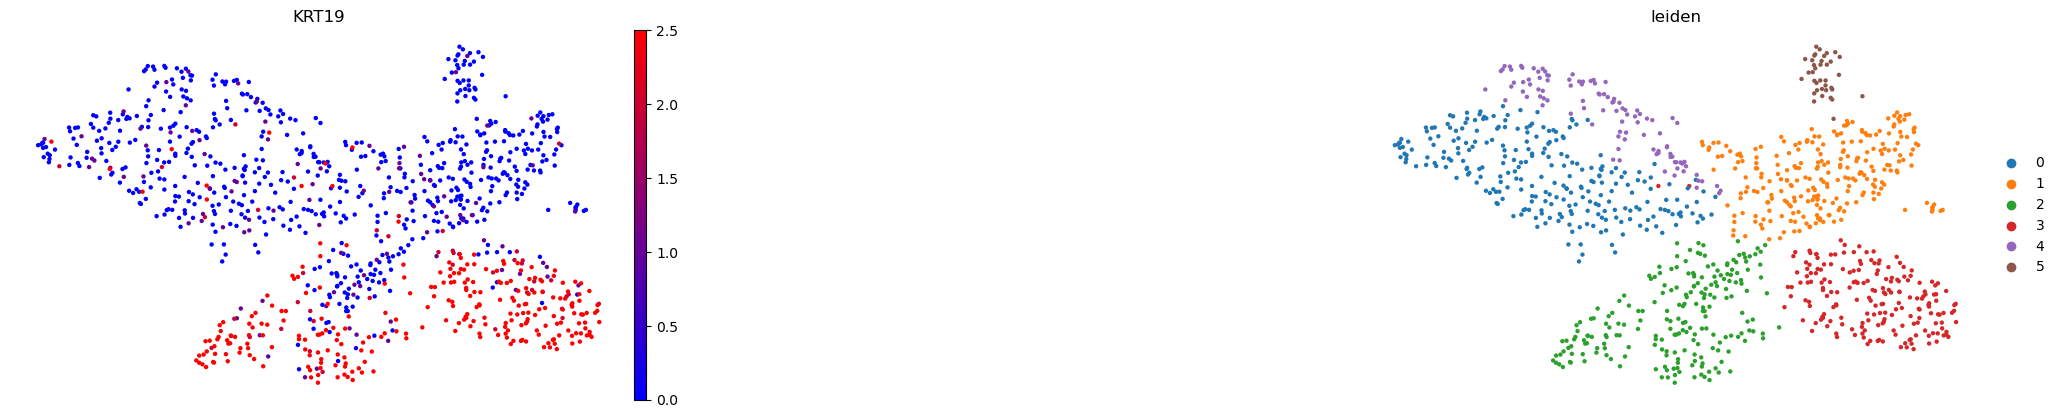

12/17
N_cells:  615


... storing 'feature_types' as categorical


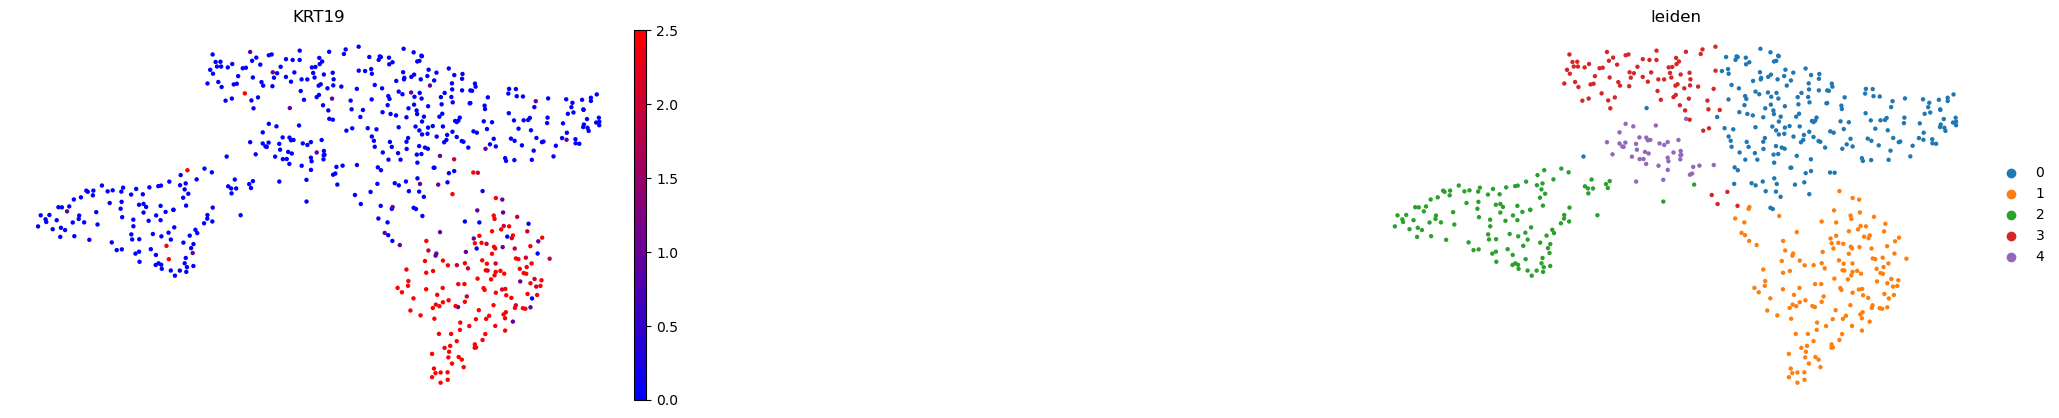

13/17
N_cells:  476


... storing 'feature_types' as categorical


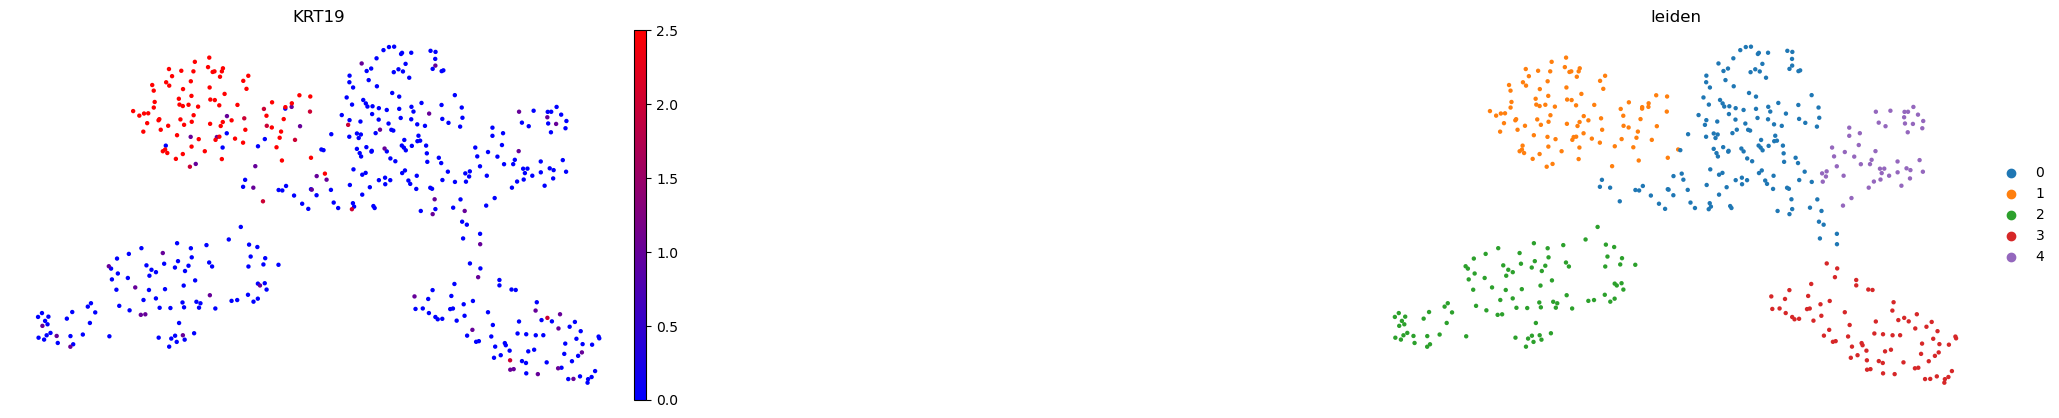

14/17
N_cells:  815


... storing 'feature_types' as categorical


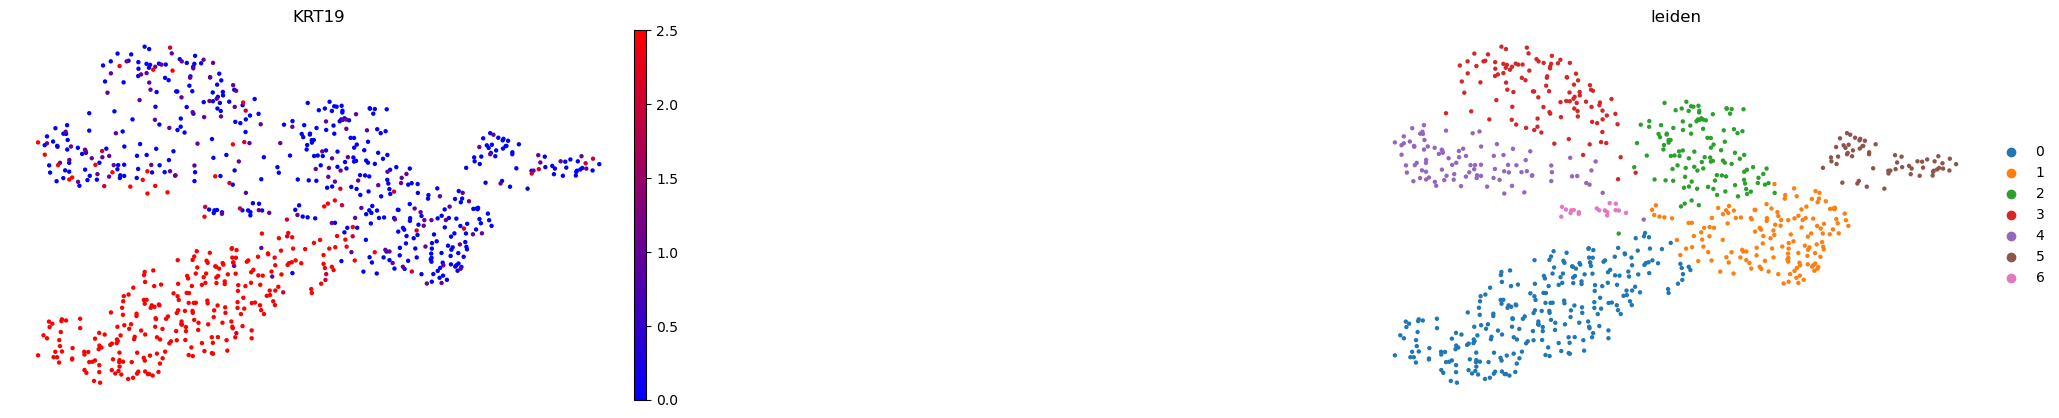

15/17
N_cells:  394


... storing 'feature_types' as categorical


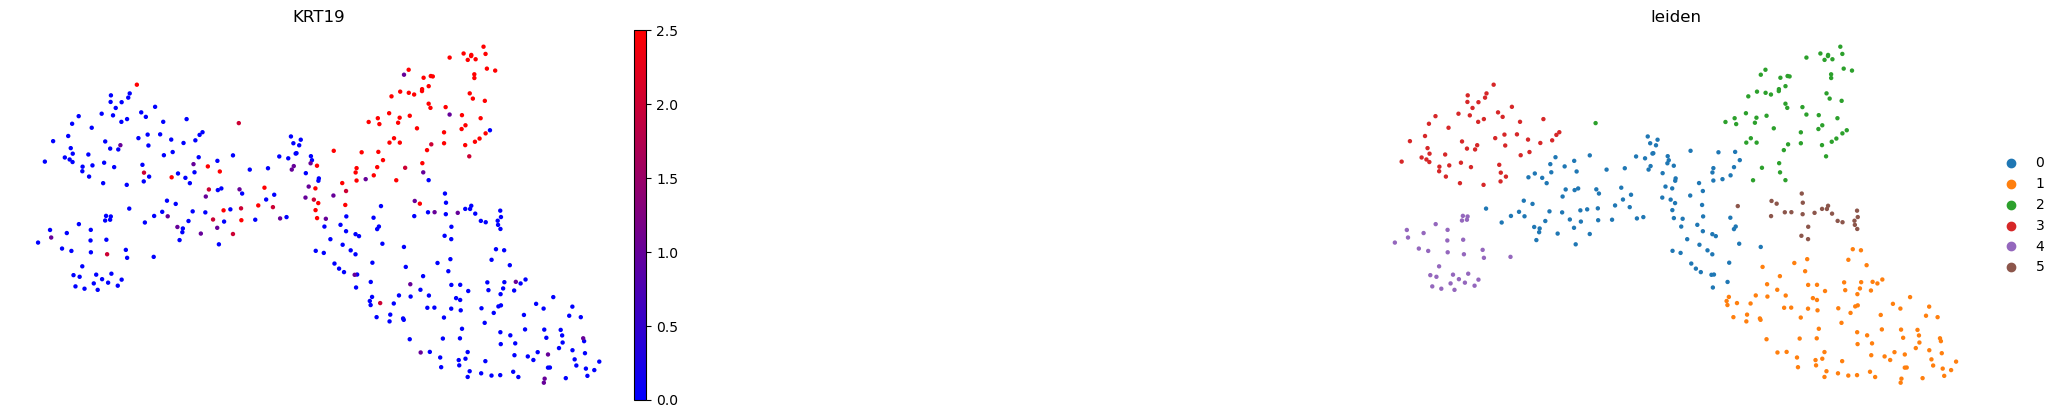

16/17


🔬 Input data has 9644 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 9644 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Sample:  P26
Resolution:  0.5
Umap:  0.5
N_neighbors:  30


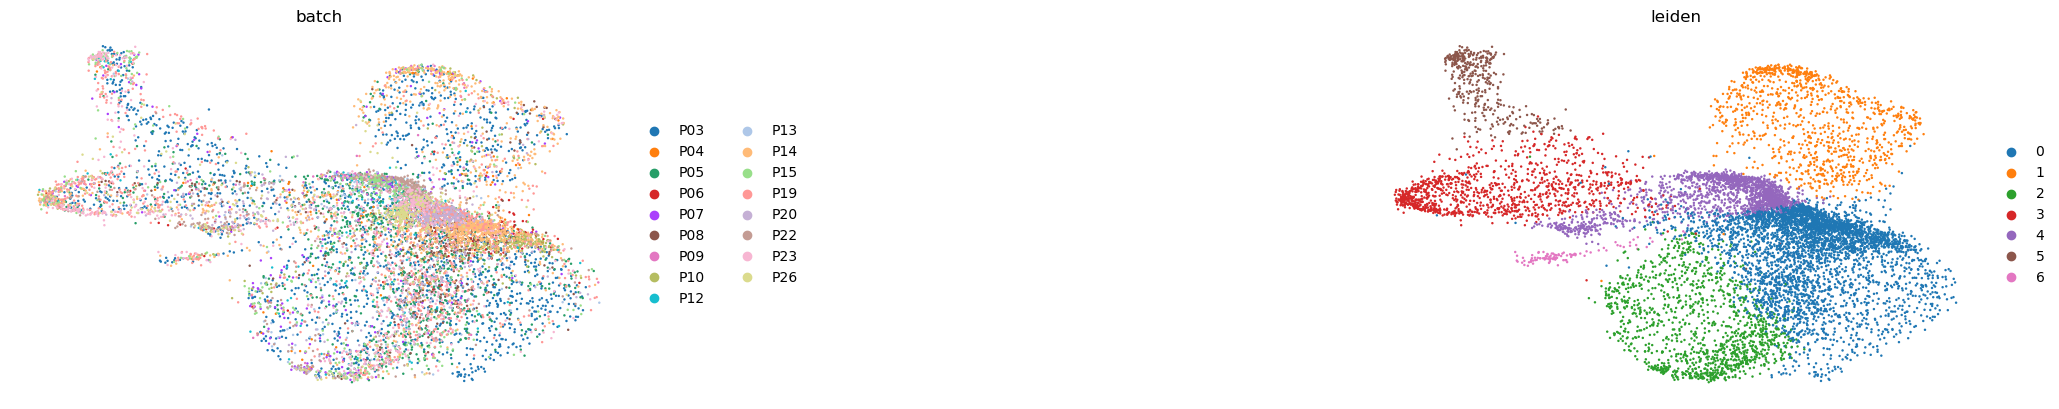

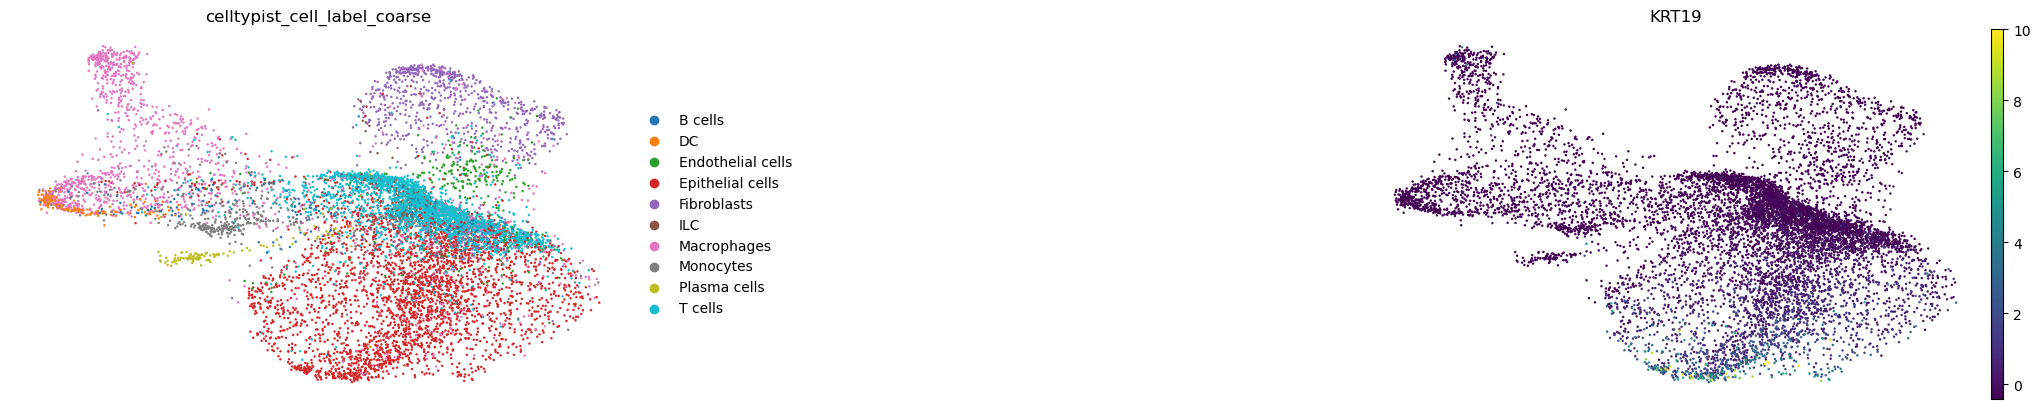

In [21]:
adata_ref =data_manipulation2(0)
adata_list = []

n = 30
u = 0.5
res = 0.5


for i in range (1,len(file_names_list)):
    adata = data_manipulation2(i)
    var_names = adata_ref.var_names.intersection(adata.var_names)
    adata_ref = adata_ref[:, var_names]
    adata = adata[:, var_names]
    if i ==1 :
        adata_ref =dim(adata_ref,n,u,res)
    print('N_cells: ',adata.n_obs)
    adata = dim(adata,n,u,res)
    sc.tl.ingest(adata, adata_ref, obs="leiden")
    
    adata_list.append(adata)
    print(f'{i}/{len(file_names_list)}')
    if i <1 :
        concat =adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])
        test(concat)

adata = adata_ref.concatenate(adata_list, batch_categories=short_names[:len(adata_list)+1])
adata = ann(adata)
sc.pp.scale(adata, max_value=10)
print('Sample: ',short_names[i])
print('Resolution: ',res)
print('Umap: ',u)
print('N_neighbors: ', n)

sc.pl.umap(
    adata,
    color=['batch','leiden'],
    frameon=False,
    sort_order=False,
    wspace=1,
)
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "KRT19"],
    frameon=False,
    sort_order=True,
    wspace=1,
)

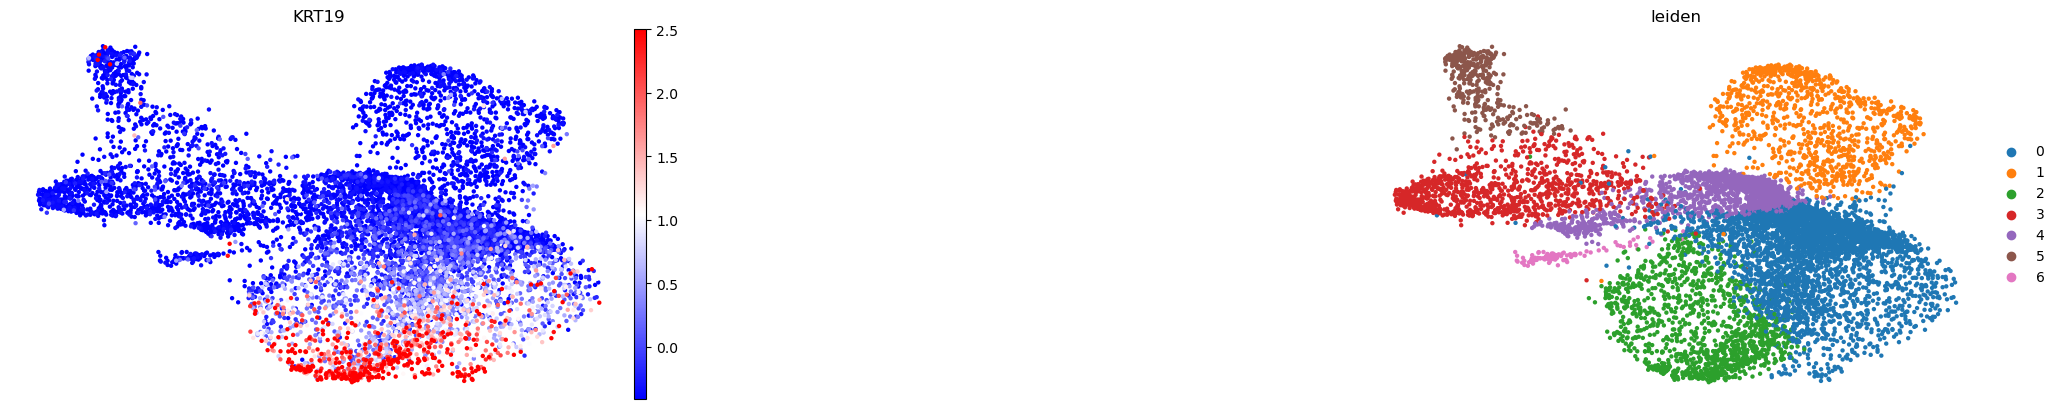

In [25]:

sc.pl.umap(
    adata,
    color= ["KRT19",'leiden'],
    frameon=False,
    sort_order=True,
    wspace=1,
    vmax = 2.5,
    color_map = cmap,
    size = 40
    #=['#ff0000','#1100ff']
)

In [19]:
print(adata.n_obs)

9644


In [20]:
adata.n_obs

9644